<center> <img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png" style="width:368px;height:81px;"> 

# Problem: Can we predict the real hotel reviews for Booking.com?

Let’s say that we work as a data scientist at Booking.com. One of the problems of the company is the dishonest hotels that twist their ratings. One way to detect such hotels is to build a model that predicts the rating of the hotel. If the predictions of the model differ greatly from the actual result, then perhaps the hotel is being dishonest and it is worth cheching it out. Let's look at the data that we have and work through it.

First we will import all the relevant dependencies we need.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data preprocessing

# libraries for data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno # library to identify and visualise missing data prior to Machine Learning

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# Split arrays or matrices into random train and test subsets 
from sklearn.model_selection import train_test_split  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# always fix RANDOM_SEED so your experiments are reproducible!
RANDOM_SEED = 42

In [4]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Loading in the data

In [5]:
# Import train & test data 
hotels_test = pd.read_csv('sf-booking/hotels_test.csv')
hotels_train = pd.read_csv('sf-booking/hotels_train.csv')
sample_submission = pd.read_csv('sf-booking/submission.csv') 

In [6]:
# IMPORTANT! for data prepocessing and engineering purposes we need to combine train and test data sets
hotels_train['sample'] = 1 # 1 = is train data set
hotels_test['sample'] = 0 # 0 = is test data set
hotels_test['reviewer_score'] = 0 # in the test data set, as we need to predict 'reviewer_score', we fill in the values with nulles

hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # data sets merging

/var/folders/vb/zgs95gns137_hr2djgnk43wc0000gn/T/ipykernel_11057/322202783.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # data sets merging


In [7]:
# view the training data
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


# Data Descriptions


**hotel_address** — hotel address; <br>

**review_date** — a date when a reviewer posted a review; <br>

**average_score** — the average hotel's calculated based on last comment left last year <br>

**hotel_name** — hotel name; <br>

**reviewer_nationality** — a country whete the reviewer is from; <br>

**negative_review** — a negative review from a reviewer; <br>

**review_total_negative_word_counts** — a number of words in a negative review; <br>

**positive_review** — a positive review from a reviewer; <br>

**review_total_positive_word_counts** — a number of words in a positive review. <br>

**reviewer_score** — the score that a reviewer gave to a hotel based on the experience; <br>

**total_number_of_reviews_reviewer_has_given** — a number of reviews that reviewers gave to hotels earlier; <br>

**total_number_of_reviews** — total number of valid hotel reviews; <br>

**tags** — the tags that the reviewer gave to the hotel; <br>

**days_since_review** — number of days between review date and cleanup date; <br>

**additional_number_of_scoring** — there are also some guests who just rated the service but did not leave a review. This number indicates how many valid grades there are without validation. <br>

**lat** — geographical latitude of the hotel; <br>

**lng** — geographical longitude of the hotel.


# Data Understanding

### What datatypes are in the dataframe?

In [8]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Target feature: reviewer_score

This is the variable we want our machine learning model to predict based off all the others.

In [9]:
# View the example submisison dataframe
sample_submission.head(3)

,reviewer_score,id
0,8.398,488440
1,7.690,274649
2,8.627,374688


# Feature Engineering

## What missing values are there?


<AxesSubplot: >

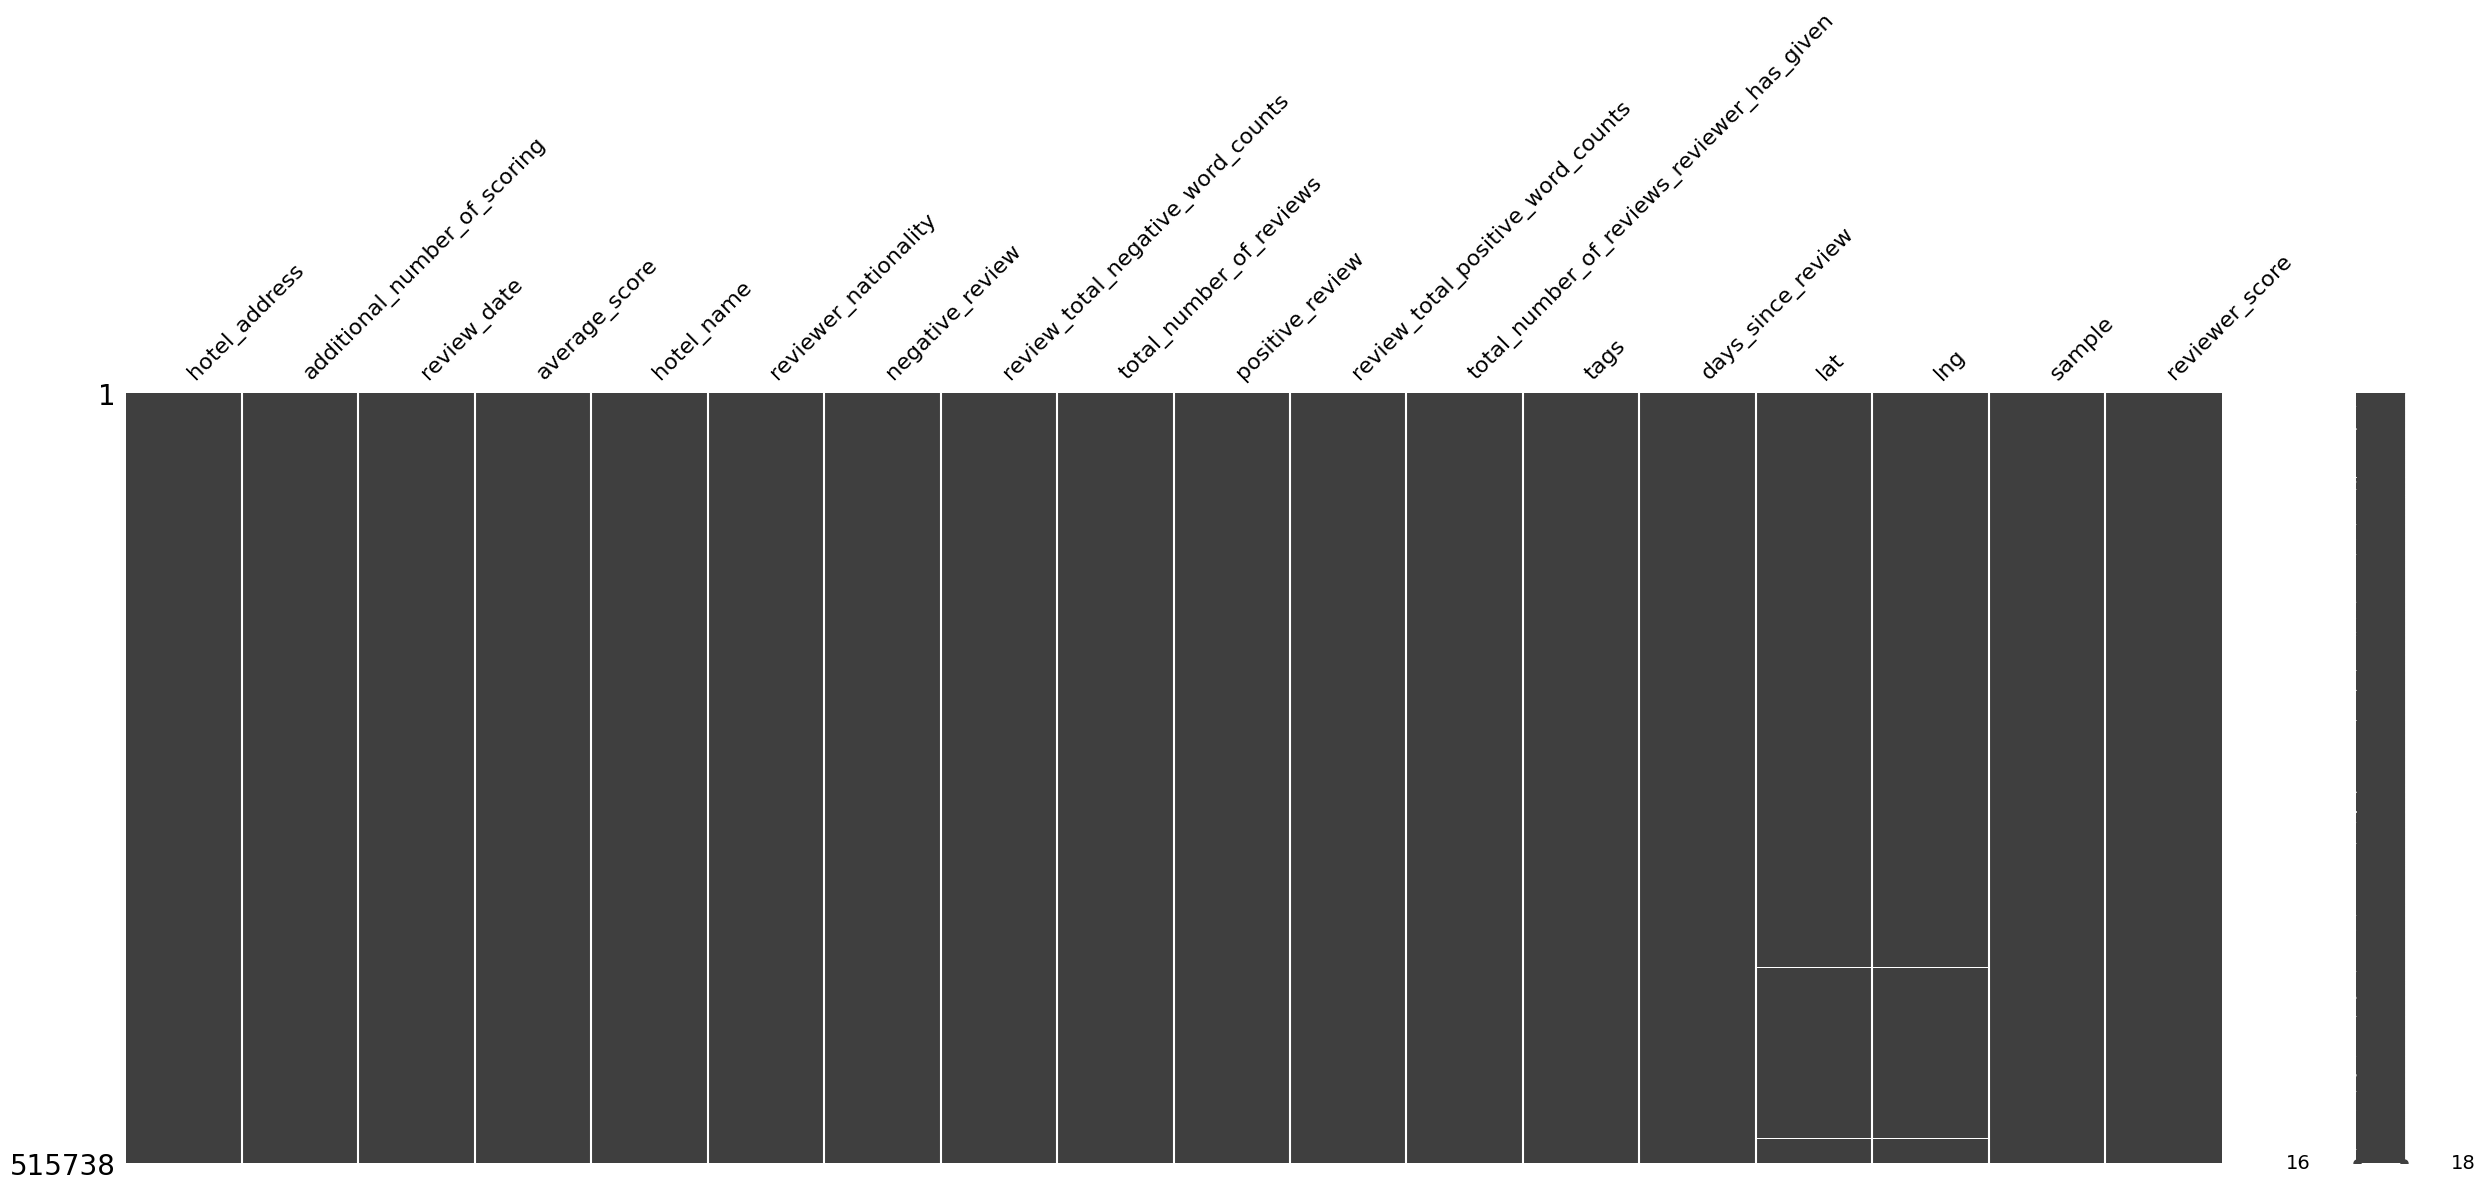

In [10]:
# Plot graphic of missing values
missingno.matrix(hotels, figsize = (30,10))

In [11]:
# Fill NA/NaN values using the specified method
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

## Feature: hotel_address and filling in the gaps in lat and lng features

In [12]:
# From the feature "hotel_address" we can "pull out" 2 features, city and country
# Adding a new feature "hotel_country"

hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels.loc[hotels['hotel_country'] == 'Kingdom','hotel_country'] = 'United Kingdom'

# Adding a new feature "hotel_city"

hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

In [13]:
# filling the gaps in the following features 'lat'  and 'lng'

values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

hotels['lat'] = hotels[['hotel_city','lat']].apply(lambda x: values_lat[x.hotel_city] if np.isnan(x.lat) else x.lat, axis=1)
hotels['lng'] = hotels[['hotel_city','lng']].apply(lambda x: values_lng[x.hotel_city] if np.isnan(x.lng) else x.lng, axis=1)

In [14]:
#Checking if there are still gaps in ou data. As we can see from thje table below, there are no more gaps!
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
dtype: int64

In [15]:
hotels.sample(10)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city
160747,Plaza Espa a 6 8 Sants Montju c 08014 Barcelon...,419,6/14/2016,8.4,Catalonia Barcelona Plaza,United Kingdom,First room we were given fixtures and fitting...,54,4527,Staff dealt with our issue quickly,7,6,"[' Leisure trip ', ' Couple ', ' Double or Twi...",415 day,41.375029,2.149117,1,4.6,Spain,Barcelona
179972,Viale Andrea Doria 4 Central Station 20124 Mil...,379,1/8/2016,8.9,Starhotels Echo,United States of America,It was noisy We just came from another hotel ...,54,3774,Very nice room,4,1,"[' Couple ', ' Superior Double or Twin Room ',...",573 day,45.484740,9.207292,1,7.5,Italy,Milan
349910,Kirchberggasse 6 07 Neubau 1070 Vienna Austria,285,3/31/2017,8.7,K K Hotel Maria Theresia,United Kingdom,Not easy to find,5,3181,Staff were helpful,4,3,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",125 day,48.203162,16.356200,1,7.9,Austria,Vienna
372437,10 Harrington Road Kensington and Chelsea Lond...,220,1/10/2016,9.1,The Ampersand Hotel,United Kingdom,No Negative,0,902,Location modern friendly,4,1,"[' Leisure trip ', ' Family with young childre...",571 day,51.494308,-0.175558,1,10.0,United Kingdom,London
265949,Passeig Colom 12 Ciutat Vella 08002 Barcelona ...,156,2/21/2016,8.9,Duquesa de Cardona,United States of America,Room felt claustrophobic dark as there was on...,24,904,Friendly staff rooftop bar with great views G...,17,45,"[' Business trip ', ' Couple ', ' Classic Doub...",529 day,41.379866,2.180527,1,7.9,Spain,Barcelona
120576,65 rue des Saints P res 6th arr 75006 Paris Fr...,63,8/6/2015,8.8,Hotel Des Saints Peres Esprit de France,United States of America,Room was really small We could not turn off t...,28,560,Great location right in the heart of Saint Ge...,18,12,"[' Leisure trip ', ' Group ', ' Club Double Ro...",728 day,48.853403,2.329904,0,0.0,France,Paris
463923,Roemer Visscherstraat 8 10 Oud West 1054 EV Am...,119,4/5/2017,8.3,Hotel Roemer Amsterdam,United Kingdom,Booked a twin room got given a double Wasn t ...,40,974,Great location walked everywhere Staff were v...,24,1,"[' Leisure trip ', ' Family with young childre...",120 day,52.361758,4.878005,1,8.3,Netherlands,Amsterdam
222822,Ballester 77 81 Gr cia 08023 Barcelona Spain,43,6/29/2017,7.4,Hotel Ronda Lesseps,Estonia,Room location inside house ground floor no wi...,23,867,Friendliness and professionalism of reception...,7,5,"[' Business trip ', ' Solo traveler ', ' Doubl...",35 days,41.408641,2.147814,1,6.7,Spain,Barcelona
323960,15 16 Prince Of Wales Terrace Kensington and C...,154,11/22/2016,8.2,Kensington House Hotel,Netherlands,The room we had was small too small The break...,41,689,At first sight the hotel is nice beautiful lo...,13,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",254 day,51.501233,-0.185994,1,5.8,United Kingdom,London
146931,Calle K s n Entrada principal Mercabarna Sants...,258,4/19/2016,7.8,Hotel Best Western PLUS Alfa Aeropuerto,United States of America,Pick up at the airport,6,2521,Meal was great,4,2,"[' Leisure trip ', ' Couple ', ' Special Offer...",471 day,41.328376,2.112964,1,9.6,Spain,Barcelona


In [16]:
hotels.to_csv('data/hotels_v2.csv')

## Feature: review_date

In [17]:
# Tasks 4.3
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format = '%m/%d/%Y')
display(hotels['review_date'])

0        2017-07-21
1        2016-12-12
2        2015-11-26
3        2015-10-17
4        2016-05-16
            ...    
515733   2017-04-19
515734   2017-02-13
515735   2016-02-07
515736   2017-05-21
515737   2016-08-05
Name: review_date, Length: 515738, dtype: datetime64[ns]

In [18]:
# adding two more features: review_year и review_month
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

In [19]:
# Now fixing the feature 'days_since_review' by removing the word "days" and leaving only numeric values

hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0])
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

## Feature: tags

In [20]:
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(re_func)

In [21]:
data_copy = hotels.explode('tags')
tags_counts = data_copy['tags'].value_counts()[:20]
data_tags_counts = pd.DataFrame(tags_counts).reset_index()
data_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(data_tags_counts['unique_tags'])

# Choose only 20 tags to create 20 new features in our dataset
# 1 - there is a tag in the review, 0 - there is no tag

for tag in top_tags:
    tag_name = str(tag)
    hotels[tag_name] =  hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)

## Fearures Encoding: hotel_country, hotel_city, and reviewer_nationality

In [22]:
# A function for features encoding
import category_encoders as ce

def one_hot_encoding(df, column_name):
    encoder = ce.OneHotEncoder(cols=[column_name])
    type_bin = encoder.fit_transform(df[column_name])
    df = pd.concat([df, type_bin], axis=1)
    df.drop([column_name], axis=1, inplace=True) 
    
    return df

In [23]:
# Now we are encoding the features of hotel_city и hotel_country
hotels["hotel_country"] = hotels["hotel_country"].astype('category')
hotels["hotel_country_code"] = hotels["hotel_country"].cat.codes

hotels["hotel_city"] = hotels["hotel_city"].astype('category')
hotels["hotel_city_code"] = hotels["hotel_city"].cat.codes

# remember the codes of the countries from data_country feature in which our hotels are located
list_country = list(hotels[['hotel_country','hotel_country_code']]['hotel_country'].unique())
data_country = pd.DataFrame({'country':list_country,'country_code':0})
data_country['country_code'] = data_country['country'].apply(lambda x: hotels[hotels['hotel_country'] == x]['hotel_country_code'].mean().astype('int')) 

In [24]:
# Remove extra spaces
def strip_text(text):
    try:
        return text.strip()
    except AttributeError:
        return text
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(strip_text)
hotels['reviewer_nationality']

# Encoding the feature 'reviewer_nationality'
hotels["reviewer_nationality"] = hotels["reviewer_nationality"].astype('category')
hotels["reviewer_nationality_code"] = hotels["reviewer_nationality"].cat.codes

In [25]:
print ('Number of unique nationalities:',hotels['reviewer_nationality_code'].max())

Number of unique nationalities: 226


In [26]:
# we will correct the nationalities of those reviewers who are from countries in which there are hotels.
# Whatever there is a mix - we will increase the codes by 10.

hotels['reviewer_nationality_code'] = hotels['reviewer_nationality_code'] +10

# using df_country 
dict_df_country = data_country.set_index('country').to_dict()['country_code']

for country, country_code in dict_df_country.items():
    hotels.loc[hotels['reviewer_nationality'] == country,['reviewer_nationality_code']] = country_code

In [27]:
# encoding the feature 'hotel_name'

hotels['hotel_name'] = hotels['hotel_name'].apply(strip_text)

hotels["hotel_name"] = hotels["hotel_name"].astype('category')
hotels["hotel_name_code"] = hotels["hotel_name"].cat.codes

## Feature: negative_review and positive_review

<div class="alert alert-info" role="alert">
Sentiment Analysis Tools   

Sentiment analysis can help you determine the ratio of positive to negative engagements about a specific topic. You can analyze bodies of text, such as comments, tweets, and product reviews, to obtain insights from your audience.
    
<img src= "https://stackabuse.s3.amazonaws.com/media/sentiment-analysis-in-python-with-textblob-1.jpg" width="400">

Reviews are very important to get a clear picture of what the customers think and why they gave to hotel such rating. I reviewed three kind analysis tools of nlp to choose most suitable ones. 
</div>

* NLTK (Natural Language ToolKit) Sentiment Analysis is the process of categorizing numerous samples of linked text into various categories using algorithms. We may use these techniques to extract insights from linguistic data with NLTK’s sophisticated built-in machine learning operations. It classifies text and gives us four values in a dictionary:
    * negative: the negative sentiment in a sentence
    * neutral: the neutral sentiment in a sentence
    * positive: the positive sentiment in the sentence
    * compound: the aggregated sentiment.                
    
      
* TextBlob Sentiment Analysis. The approach that the TextBlob package applies to sentiment analysis differs in that it’s rule-based and therefore requires a pre-defined set of categorized words. These words can, for example, be uploaded from the NLTK database. Moreover, sentiments are defined based on semantic relations and the frequency of each word in an input sentence that allows getting a more precise output as a result.    
    TextBlob’s output for a polarity task is a float within the range [-1.0, 1.0] where -1.0 is a negative polarity and 1.0 is positive. This score can also be equal to 0, which stands for a neutral evaluation of a statement as it doesn’t contain any words from the training set.    
    Whereas, a subjectivity/objectivity identification task reports a float within the range [0.0, 1.0] where 0.0 is a very objective sentence and 1.0 is very subjective.  
    
* TextBlob's .sentiment + NaiveBayesAnalyzer. TextBlob's other option uses a NaiveBayesAnalyzer, which is a machine learning technique. When you use this option with TextBlob, the sentiment is coming from NLTK classifier trained on a movie reviews corpus.  
    It returns results as a namedtuple of the form: Sentiment(classification, p_pos, p_neg), here neutral position of the p_pos and p_neg values is 0.5.  
    
    <img src="https://dev-gang.ru/static/storage/260221293701977790295363160988809390228.jpg" width="600">
    
<div class="alert alert-info" role="alert">
However, before analyzing by this tools, we need to prepare text because words like 'No Negative', 'Nothing' can give don't right result, so I changed them to "" and then I did review how these tools work.
</div>

In [28]:
# analysis of the features 'negative_review' and 'positive_review'.
# Let's process themusing the SentimentIntensityAnalyzer of the VADER library

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# First of all, we fix the explicit expressions
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

# create two parser instances to separate the lexicon
# for a different rating system for positive and negative reviews:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

hotels['neg_scores'] = hotels['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
hotels['pos_scores'] = hotels['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# create new features
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].apply(lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alina/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# removing nominal categorical data and dates
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

object_category = [s for s in hotels.columns if hotels[s].dtypes == 'category']
hotels.drop(object_category, axis = 1, inplace=True)

object_data = [s for s in hotels.columns if hotels[s].dtypes == 'datetime64[ns]']
hotels.drop(object_data, axis = 1, inplace=True)
# We removed all non-numeric features from our dataset, because the model cannot be trained using non-numeric data

In [30]:
hotels.head(5)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,reviewer_nationality_code,hotel_name_code,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
0,904,8.1,52,16670,62,1,13,45.533137,9.171102,0,...,5,612,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615
1,612,8.6,10,5018,0,7,234,52.385649,4.834443,0,...,32,1445,0.216,0.784,0.000,-0.2960,1.0,0.000,0.000,-0.5719
2,46,8.3,3,351,5,15,616,41.393192,2.161520,0,...,206,33,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908
3,241,9.1,0,1543,27,9,656,45.479888,9.196298,0,...,226,735,0.000,0.000,1.000,0.5574,0.0,0.621,0.379,0.9153
4,834,9.1,0,4687,7,2,444,52.370545,4.888644,0,...,5,633,0.000,0.000,1.000,0.5574,0.0,0.230,0.770,0.7717


In [31]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

# Model 

In [32]:
# Break the dataframe in to train and test dataset for the model
# X - data with information about hotels, y - target variable (hotel ratings)

X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

# Feature Assessment and Selection

<AxesSubplot: >

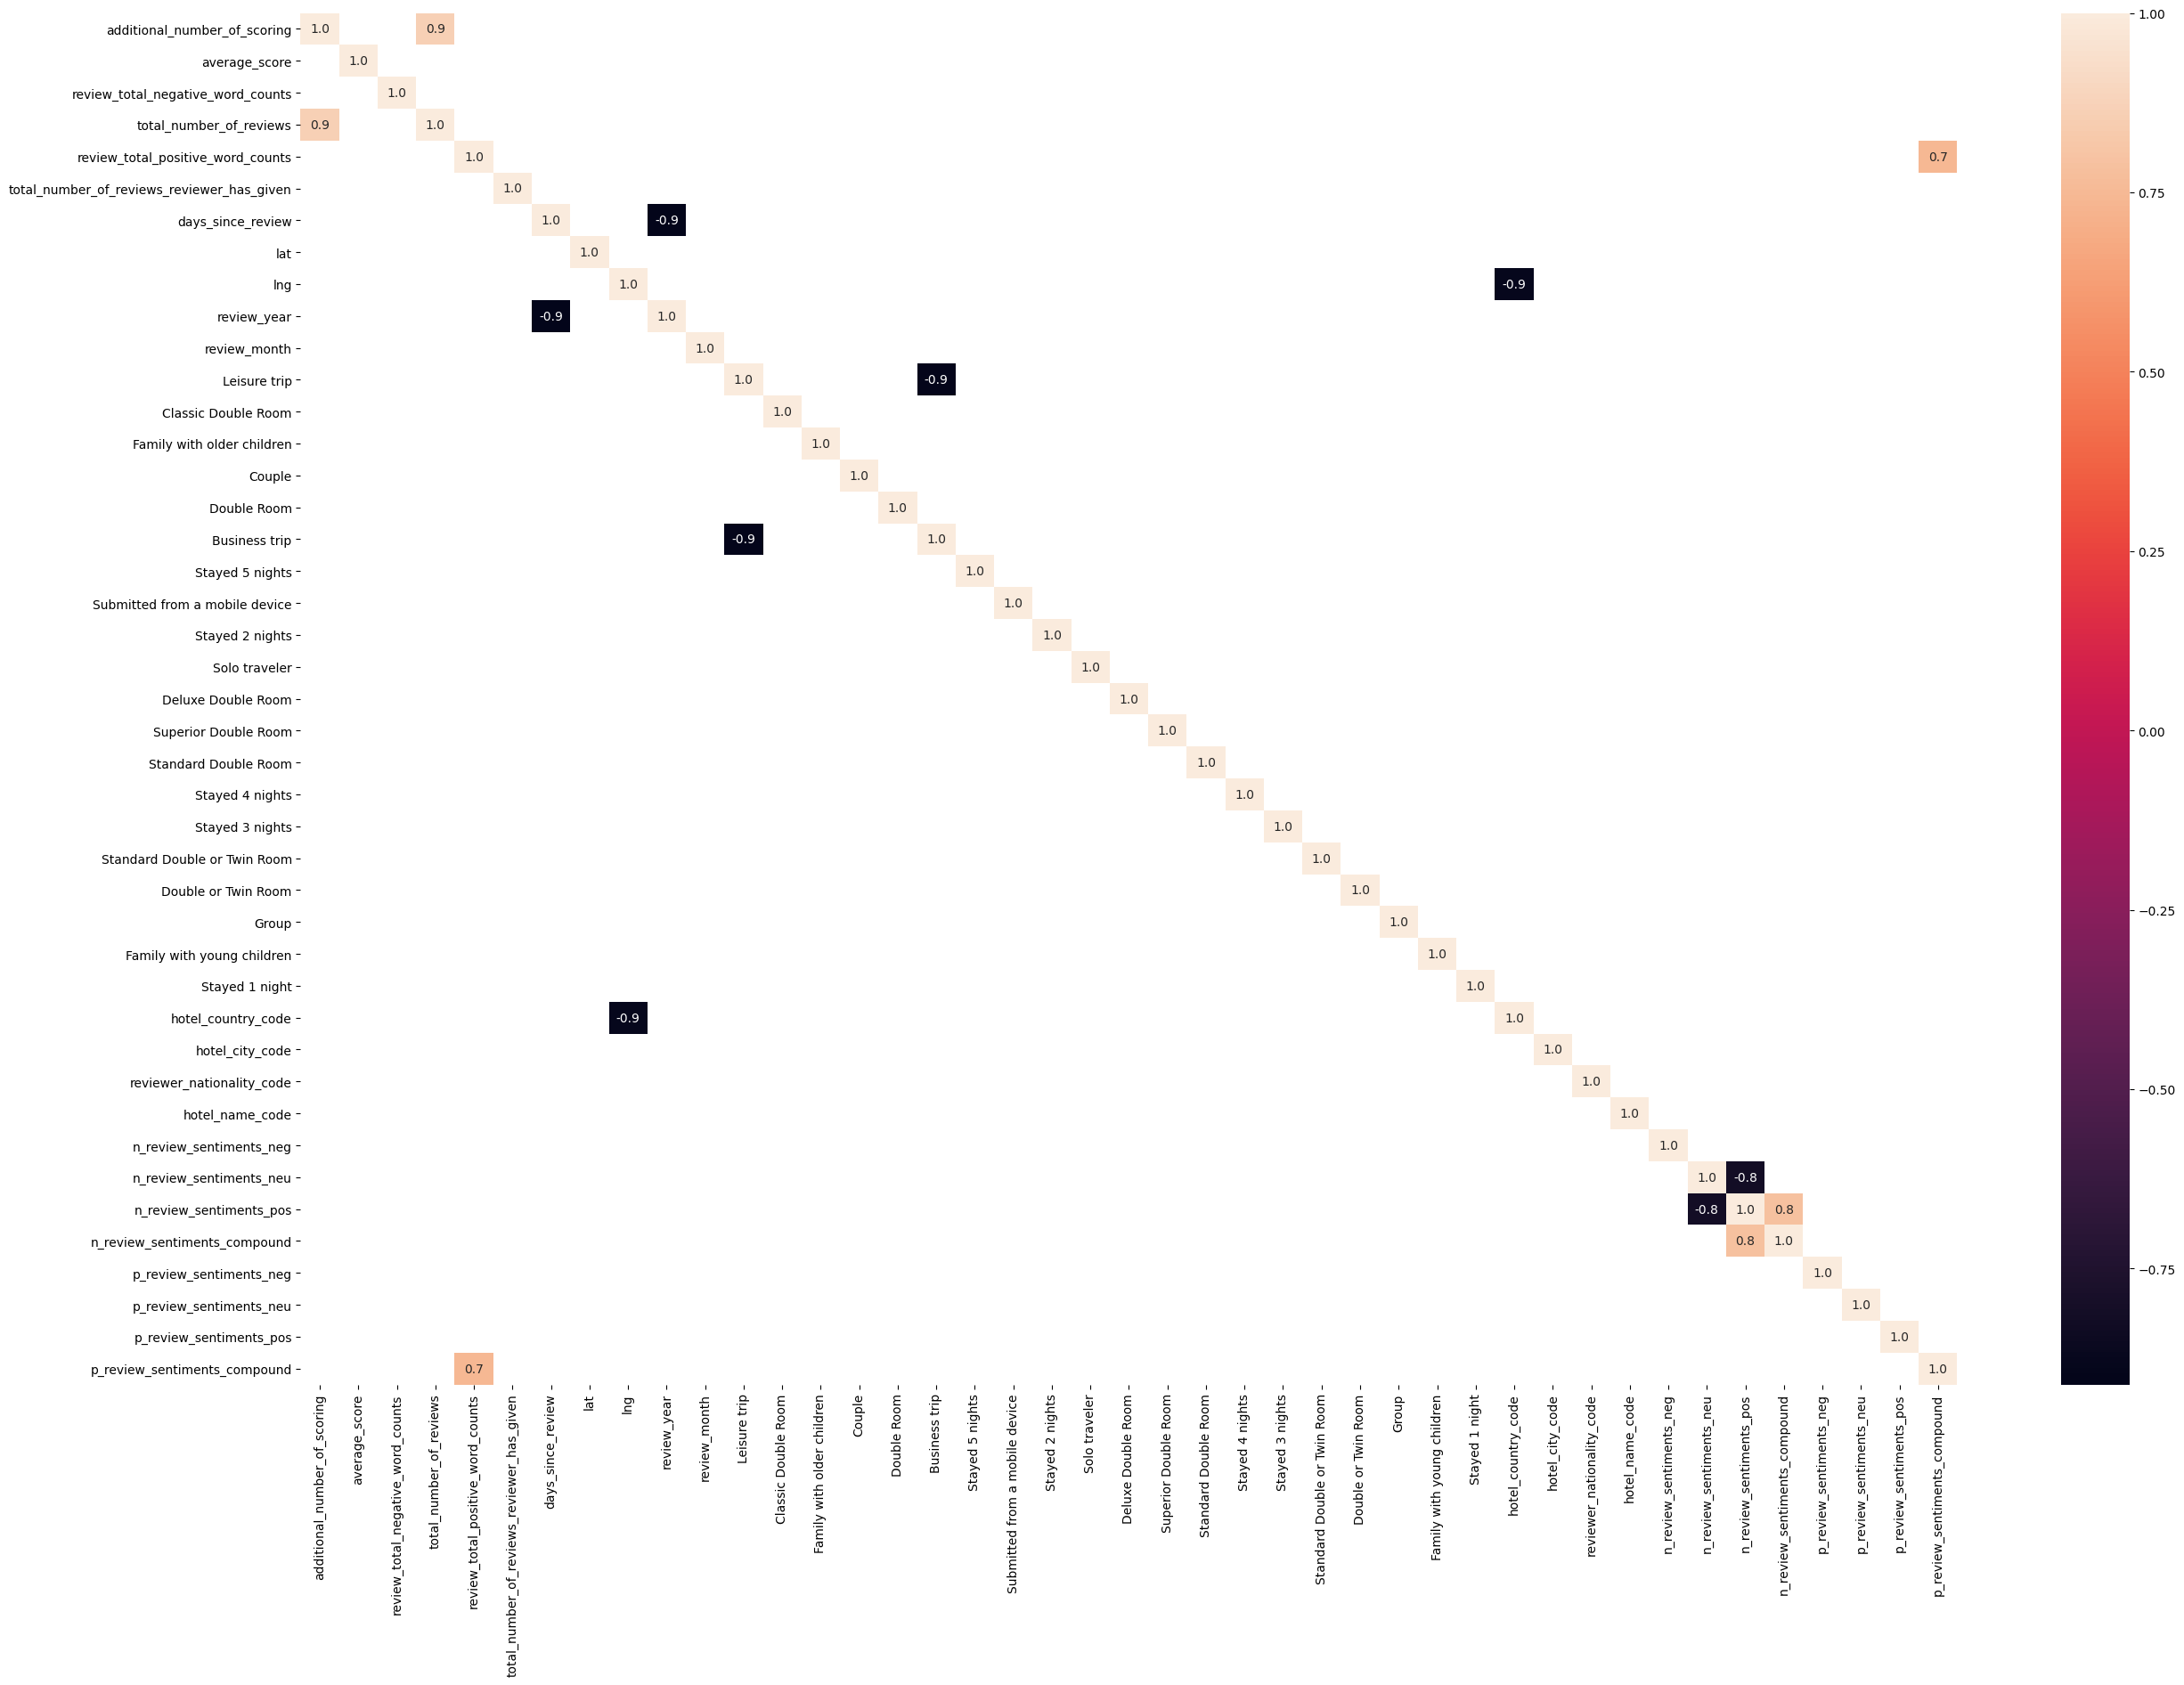

In [33]:
# creating correlation heatmap by using spearman method 
corr_df = hotels.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(corr_df[corr_df.abs() > 0.7], annot = True,  fmt='.1f')

In [34]:
hotels.drop(["review_year", "lat", "lng"], axis = 1, inplace=True)
# showing list of left columns 
list(hotels.columns)

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'sample',
 'reviewer_score',
 'review_month',
 'Leisure trip',
 'Classic Double Room',
 'Family with older children',
 'Couple',
 'Double Room',
 'Business trip',
 'Stayed 5 nights',
 'Submitted from a mobile device',
 'Stayed 2 nights',
 'Solo traveler',
 'Deluxe Double Room',
 'Superior Double Room',
 'Standard Double Room',
 'Stayed 4 nights',
 'Stayed 3 nights',
 'Standard Double or Twin Room',
 'Double or Twin Room',
 'Group',
 'Family with young children',
 'Stayed 1 night',
 'hotel_country_code',
 'hotel_city_code',
 'reviewer_nationality_code',
 'hotel_name_code',
 'n_review_sentiments_neg',
 'n_review_sentiments_neu',
 'n_review_sentiments_pos',
 'n_review_sentiments_compound',
 'p_review_sentiments_neg',
 'p_review_sentiments_neu',
 'p_review_sentiments_p

In [35]:
# Let's divide all features into 2 groups:
# continuous features
num_cols = ['additional_number_of_scoring',
            'average_score',
            'review_total_negative_word_counts', 
            'total_number_of_reviews',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'days_since_review',
            'n_review_sentiments_neg',
            'n_review_sentiments_neu',
            'n_review_sentiments_pos',
            'n_review_sentiments_compound',
            'p_review_sentiments_neg',
            'p_review_sentiments_neu',
            'p_review_sentiments_pos',
            'p_review_sentiments_compound'          
]

# categorical features (ordinal)
cat_cols = ['Double Room',
            'Standard Double or Twin Room',
            'Group',
            'Deluxe Double Room',
            'Family with older children',
            'Family with young children',
            'Solo traveler',
            'Double or Twin Room',
            'Classic Double Room',
            'Stayed 1 night',
            'Stayed 2 nights',
            'Stayed 3 nights',
            'Stayed 4 nights',
            'Stayed 5 nights',
            'Leisure trip',
            'Submitted from a mobile device',
            'Superior Double Room',
            'Standard Double Room',
            'Business trip',
            'Couple',
            'hotel_country_code',
            'hotel_city_code',
            'review_month', 
            'reviewer_nationality_code',
            'hotel_name_code'
]

## Assessment of numerical variables

<AxesSubplot: >

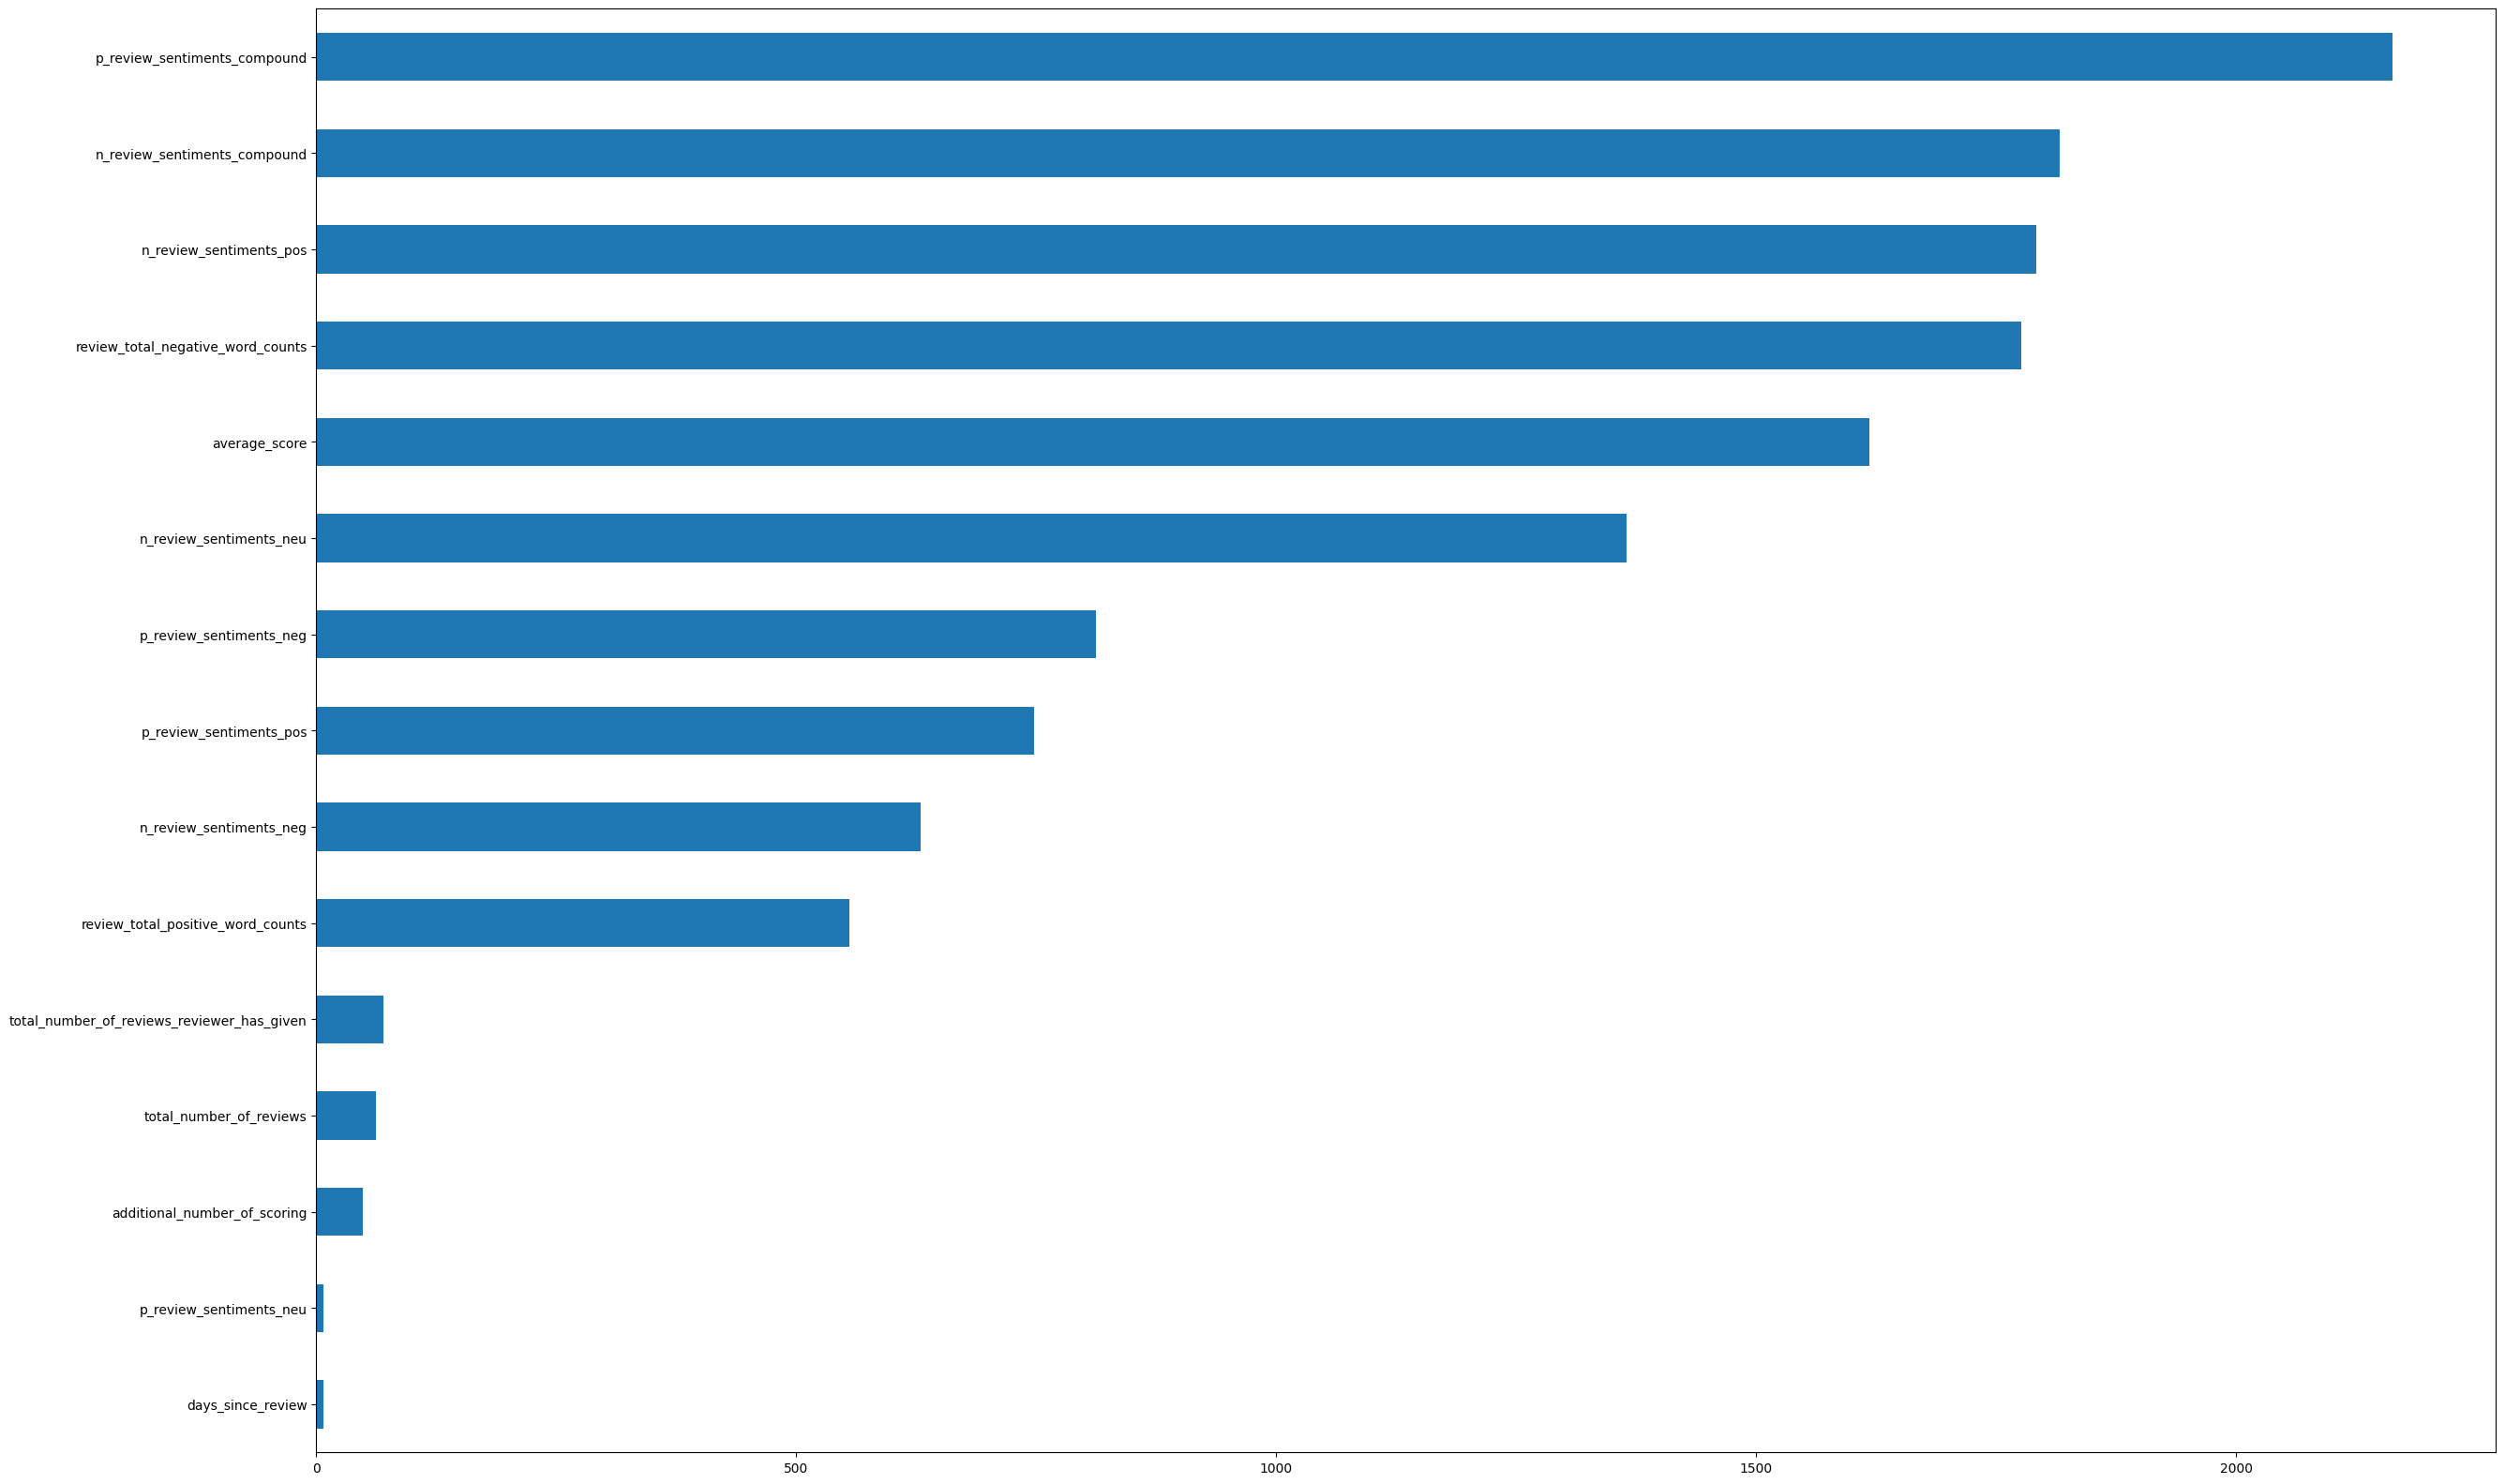

In [36]:
# to assess the significance of numerical variables 
# we will use the function f_classif

from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

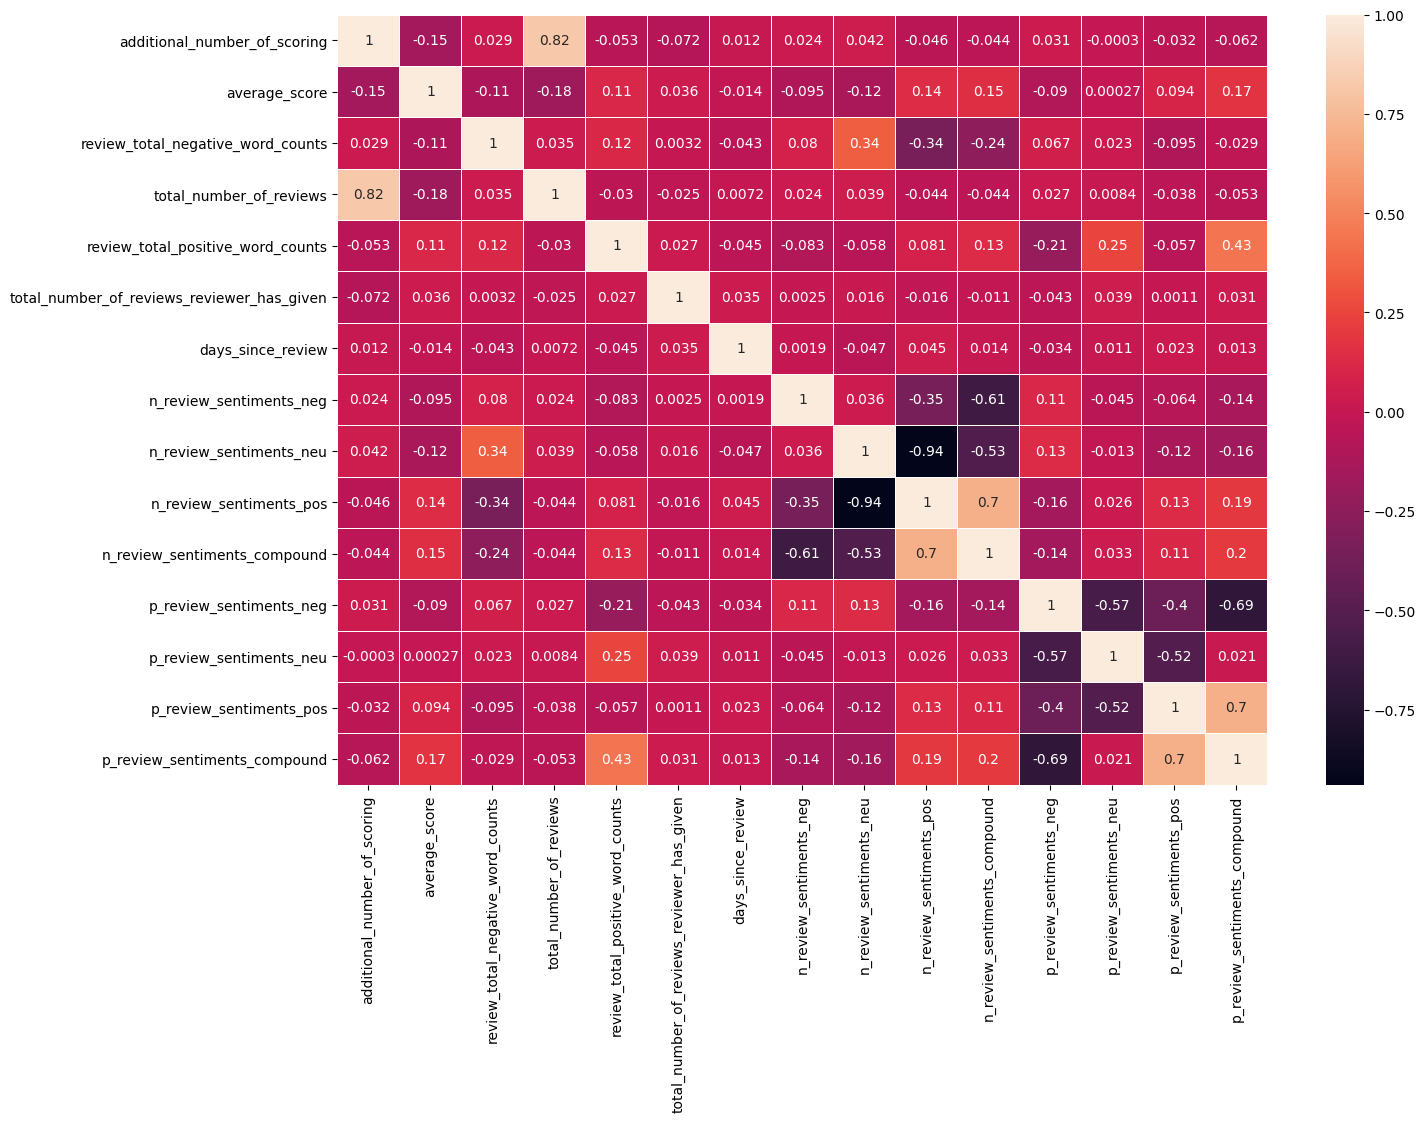

In [37]:
#Let's carry out a correlation analysis with a visualization for 2 groups separately for more convenience.
#First, we conduct a correlation analysis with visualization for continuous features
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels[num_cols].corr(method='pearson'), annot=True, linewidths=.5, ax=ax, fmt='.2g');

## Assessment of categorical variables

<AxesSubplot: >

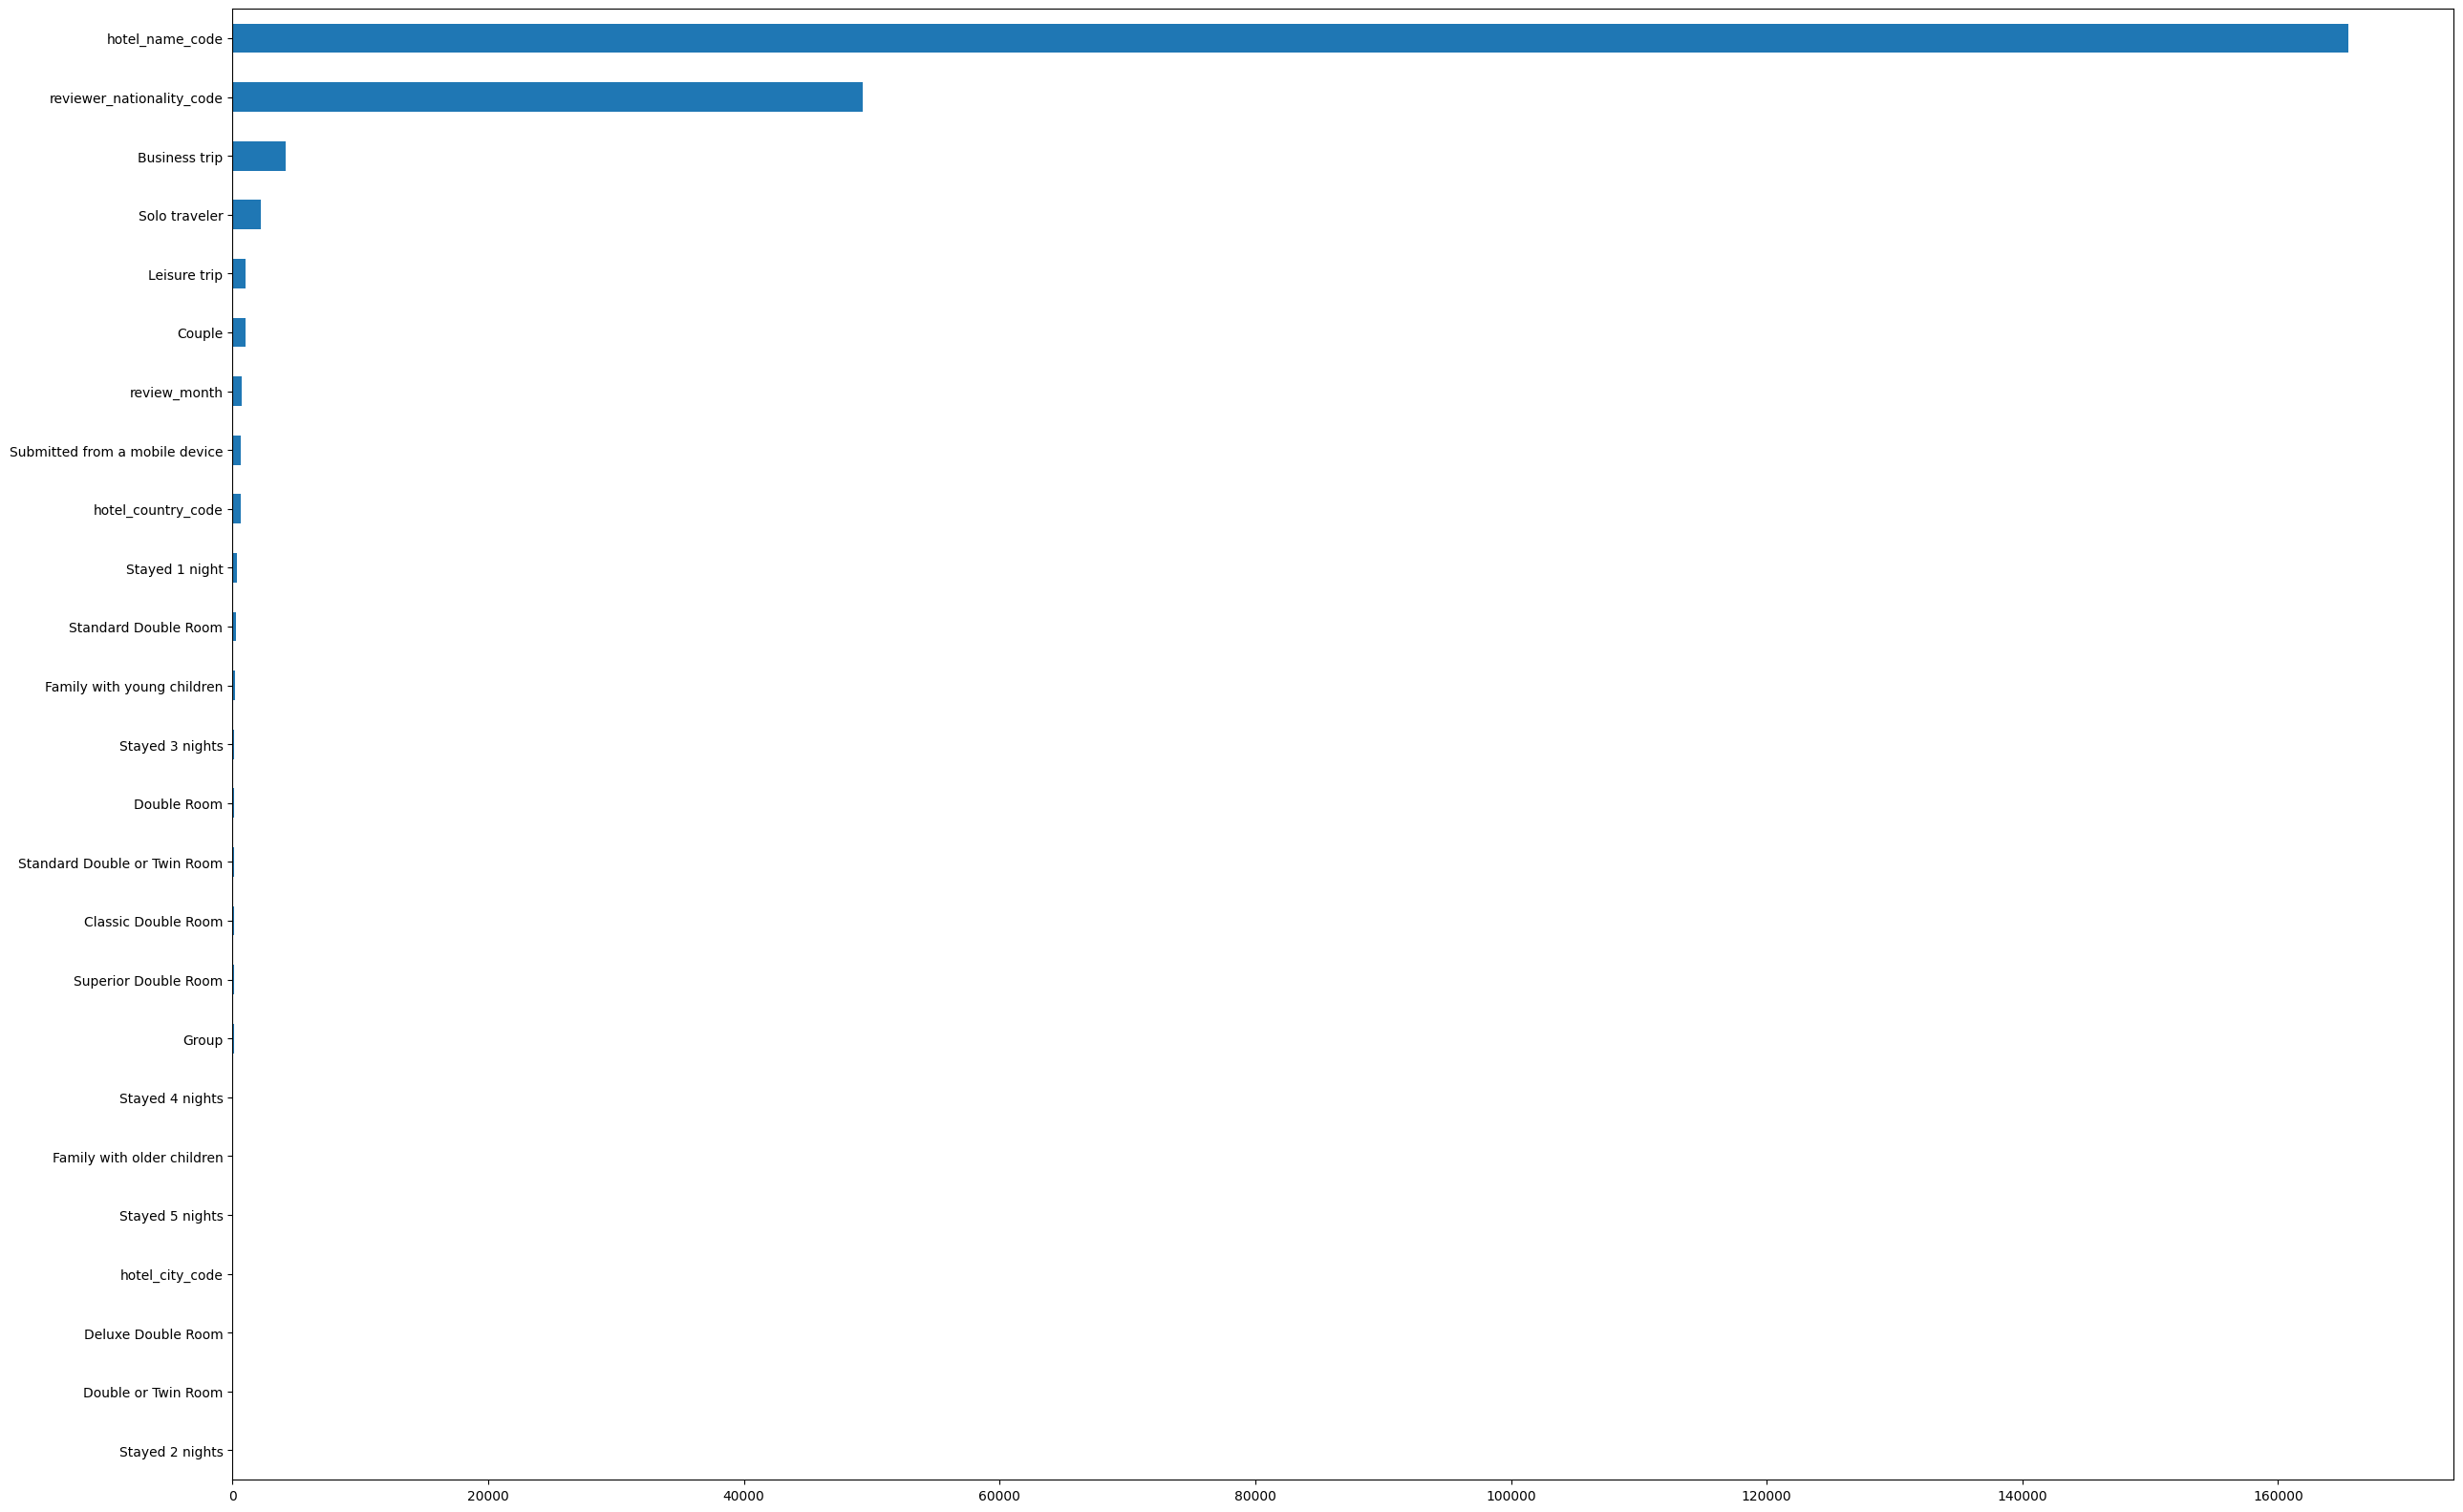

In [38]:
y = y.astype('int')

from sklearn.feature_selection import chi2 # chi-square

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

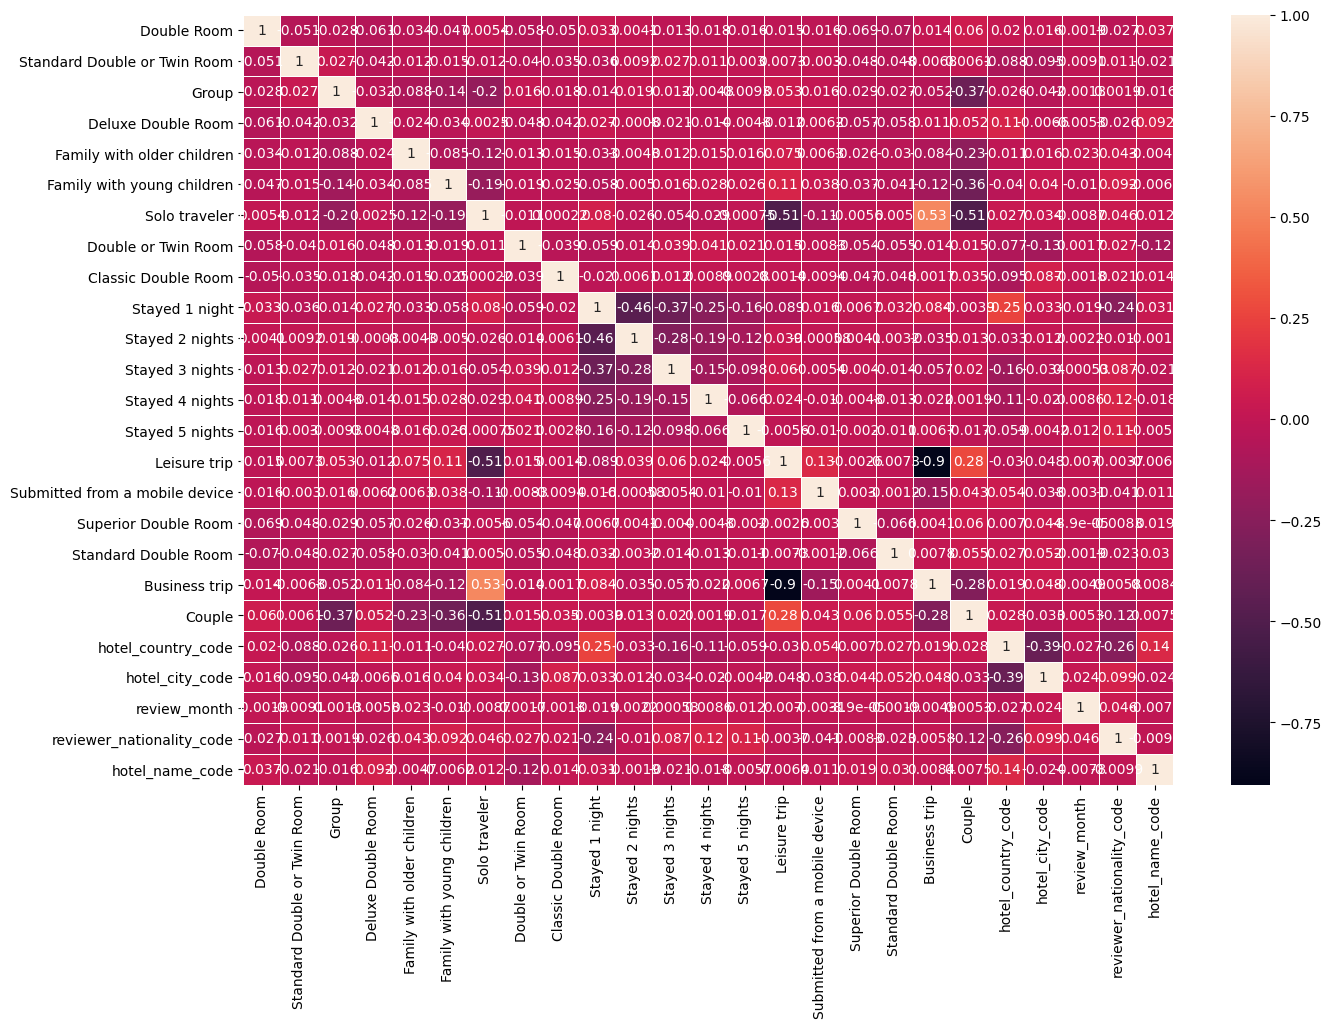

In [39]:
# use Spearman correlation for categorical features
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels[cat_cols].corr(method = 'spearman'), annot=True, linewidths=.5, ax=ax, fmt='.2g');


In [40]:
drop_cols = ['additional_number_of_scoring','total_number_of_reviews', 'n_review_sentiments_neu','Business trip', 'Leisure trip']

hotels.drop(drop_cols, axis = 1, inplace=True)

In [41]:
# dividing dataset into train and test 
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # target value          
X = train_data.drop(['reviewer_score'], axis=1)

In [42]:
# Load the custom splitting tool:
from sklearn.model_selection import train_test_split  

In [43]:
# Datasets labeled "train" will be used for training the model, "test" for testing model.
# For testing, we will use 25% of the original dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [44]:
# testing
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 36), (386803, 36), (386803, 35), (290102, 35), (96701, 35))

In [45]:
# Import the necessary libraries: 
from sklearn.ensemble import RandomForestRegressor # a tool for creating and training a model
from sklearn import metrics # tools for evaluating model accuracy 
  
# Create model 
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Train the model on the test dataset
regr.fit(X_train, y_train)  
      
# Use the trained model to predict the rating of hotels in the test set.
# The predicted values are written to the variable y_pred
 
y_pred = regr.predict(X_test)  


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [46]:
# Compare the predicted values (y_pred) with the real values (y_test), and see how they differ
# The metric is called Mean Absolute Percentage Error (MAPE)
# and shows the average absolute percentage error of the predicted values from the actual ones.

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12506882735744088


<AxesSubplot: >

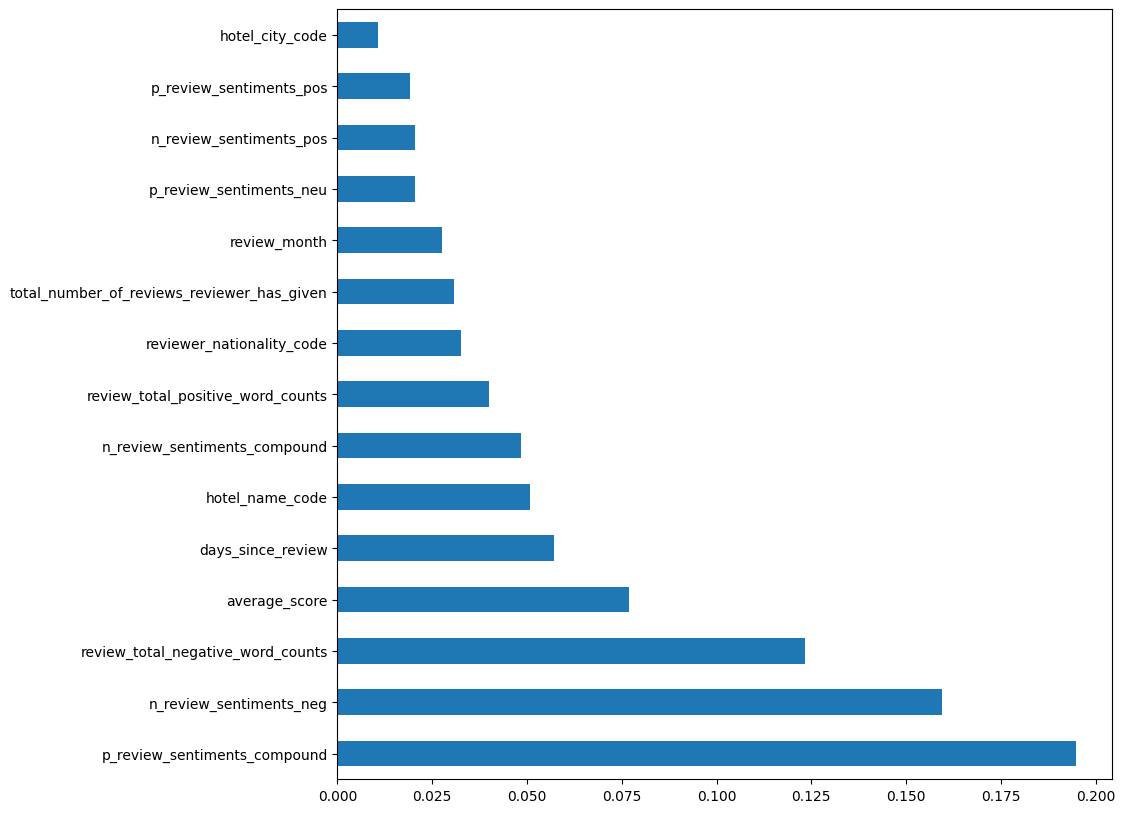

In [47]:
# in RandomForestRegressor it is possible to display the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [48]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,review_month,Classic Double Room,Family with older children,Couple,...,hotel_city_code,reviewer_nationality_code,hotel_name_code,n_review_sentiments_neg,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
39941,8.3,13,8,1,291,0.0,10,0,0,0,...,2,5,1174,0.285,0.000,-0.4563,0.000,0.411,0.589,0.7996
43025,8.4,6,5,17,287,0.0,10,0,0,0,...,5,101,781,0.000,0.000,0.0000,0.000,0.448,0.552,0.5719
87763,8.0,9,17,3,173,0.0,2,0,0,1,...,2,53,1419,0.000,0.000,0.0000,0.146,0.854,0.000,-0.3400
71625,8.9,12,15,33,267,0.0,11,0,0,0,...,0,101,819,0.000,0.225,0.4404,0.000,0.808,0.192,0.4754
121196,7.6,63,3,4,605,0.0,12,0,0,1,...,1,223,1195,0.046,0.000,-0.3875,0.000,1.000,0.000,0.0000
3365,8.4,10,9,1,438,0.0,5,0,0,1,...,2,5,1335,0.149,0.000,-0.1027,0.000,0.397,0.603,0.8225
56603,8.4,17,20,1,465,0.0,4,0,0,0,...,2,88,1335,0.108,0.000,-0.1779,0.000,0.459,0.541,0.9360
9462,8.4,0,10,2,230,0.0,12,0,0,0,...,2,5,5,0.000,1.000,0.5574,0.000,0.238,0.762,0.9153
58858,7.9,9,2,7,640,0.0,11,0,0,1,...,4,207,991,0.000,0.000,0.0000,0.000,1.000,0.000,0.0000
124226,8.1,22,22,23,316,0.0,9,0,0,0,...,1,5,558,0.000,0.231,0.6249,0.000,0.685,0.315,0.8316


In [49]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [50]:
sample_submission

,reviewer_score,id
0,8.398,488440
1,7.690,274649
2,8.627,374688
3,9.627,404352
4,9.558,451596
...,...,...
128930,8.653,495812
128931,9.429,315577
128932,8.182,511968
128933,9.595,303386


In [51]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


In [52]:
predict_submission

array([8.369, 7.441, 8.533, ..., 8.131, 9.59 , 7.206])

In [53]:
list(sample_submission)

['reviewer_score', 'id']

In [55]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('sf-booking/submission_v1.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.369,488440
1,7.441,274649
2,8.533,374688
3,9.750,404352
4,9.604,451596
5,8.863,302161
6,7.446,317079
7,7.440,13963
8,8.230,159785
9,7.653,195089
